In [0]:
!pip install keract

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
os.chdir('/content/drive/My Drive/MVA/S2/DLMI')

# Imports

In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
import keract
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import keras
import tensorflow as tf
import matplotlib.font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from utils.evaluation import *
from utils.utils import read_dataset,split_dataset
%matplotlib inline

Using TensorFlow backend.


# 1. Data importation and visualization

In [0]:
data,labels = read_dataset('mitbih_train.csv','MIT-BIH')

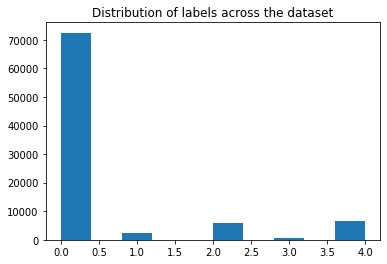

In [5]:
plt.hist(labels)
plt.title('Distribution of labels across the dataset')
plt.show()

In [6]:
unique_labels,props = np.unique(labels,return_counts=True)
df_props = pd.DataFrame([],columns=['proportion'],index = unique_labels)
df_props.index.name='label'
df_props['proportion'] = props/np.sum(props)
df_props

,proportion
label,
0,0.827729
1,0.025390
2,0.066108
3,0.007321
4,0.073452


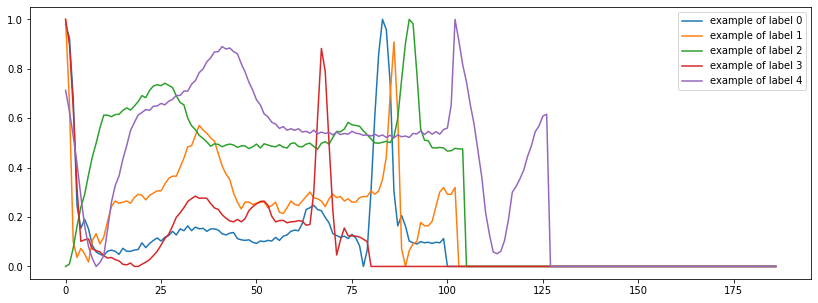

In [7]:
fig = plt.figure(figsize=(14,5))
for c in set(labels):
    spe_ecg = data[labels==c][0]
    plt.plot(spe_ecg,label='example of label '+str(c))

plt.legend()
plt.show()

# 2. Splitting dataset

We first split the dataset into three parts (training validation test), while keeping the proportions intact.

In [0]:
xtrain,ytrain,xval,yval,y_val_true, xtest,ytest,y_test_true = split_dataset(data,labels,validation=True)

# 3. Testing models

In [0]:
%matplotlib inline

## 3.1 Test MLP

In [0]:
from models.mlp import Classifier_MLP

In [13]:
mlp = Classifier_MLP(output_directory='output_mlp/',input_shape=(data.shape[1],),nb_classes = 5,verbose=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 187)               0         
_________________________________________________________________
dropout (Dropout)            (None, 187)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               94000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0     

Train on 52532 samples, validate on 17511 samples
Epoch 1/10
52532/52532 [==============================] - 3s 61us/sample - loss: 1.3522 - acc: 0.6859 - val_loss: 1.1132 - val_acc: 0.8277
Epoch 2/10
52532/52532 [==============================] - 3s 50us/sample - loss: 0.9673 - acc: 0.8277 - val_loss: 0.8694 - val_acc: 0.8277
Epoch 3/10
52532/52532 [==============================] - 3s 50us/sample - loss: 0.8417 - acc: 0.8277 - val_loss: 0.8029 - val_acc: 0.8277
Epoch 4/10
52532/52532 [==============================] - 3s 49us/sample - loss: 0.7992 - acc: 0.8277 - val_loss: 0.7651 - val_acc: 0.8277
Epoch 5/10
52532/52532 [==============================] - 3s 50us/sample - loss: 0.7659 - acc: 0.8277 - val_loss: 0.7319 - val_acc: 0.8277
Epoch 6/10
52532/52532 [==============================] - 3s 50us/sample - loss: 0.7401 - acc: 0.8277 - val_loss: 0.7007 - val_acc: 0.8277
Epoch 7/10
52532/52532 [==============================] - 3s 51us/sample - loss: 0.7132 - acc: 0.8277 - val_loss: 0.

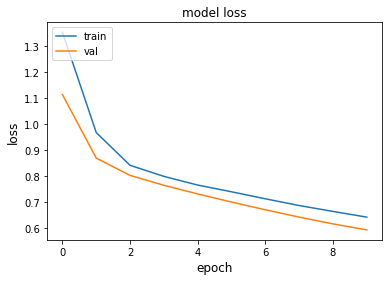

In [14]:
hist = mlp.fit(xtrain,ytrain,xval,yval,y_true,batch_size=64,nb_epochs=10)

Let's evaluate our predictions on the validation set: 

In [15]:
ypred = mlp.predict(xval,np.argmax(yval,axis=1),return_df_metrics=False)
ypred = np.argmax(ypred,axis=1)
evaluate(y_true,ypred)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


,accuracy,recall,precision,f1-score
0,0.827708,0.2,0.165542,0.181147


Let's be more precise on each class. The following scores are computed considering each label against all the others.

In [16]:
get_binary_metrics(y_true,ypred)

,recall,precision,f1-score
0,1,0.827708,0.905733
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## 3.2 Test ResNet

In [0]:
from models.resnet import Classifier_RESNET

In [0]:
#resnet requires a different shape since it is based on convolutional layers
xtrain_r = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
xval_r = xval.reshape(xval.shape[0],xval.shape[1],1)

In [8]:
resnet = Classifier_RESNET('output_resnet/',input_shape=(data.shape[1],1),nb_classes=5,verbose=1,load_weights=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 187, 64)      576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 187, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

Train on 52532 samples, validate on 17511 samples
Epoch 1/2
52532/52532 [==============================] - 33s 623us/sample - loss: 0.1921 - accuracy: 0.9462 - val_loss: 0.2189 - val_accuracy: 0.9305
Epoch 2/2
52480/52532 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9639

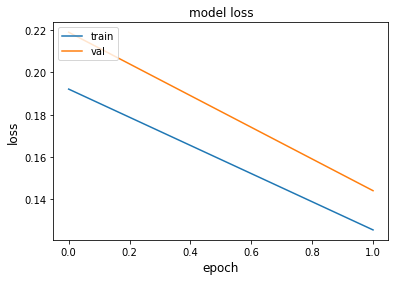

In [9]:
%matplotlib inline
hist = resnet.fit(xtrain_r,ytrain,xval_r,yval,y_val_true,batch_size=32,nb_epochs=2)

In [10]:
ypred = resnet.predict(xval_r,np.argmax(yval,axis=1),return_df_metrics=False)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

,accuracy,recall,precision,f1-score
0,0.959397,0.775616,0.903069,0.810847


In [11]:
get_binary_metrics(y_val_true,ypred)

,recall,precision,f1-score
0,0.97668,0.981964,0.979315
1,0.513514,0.904762,0.655172
2,0.953368,0.754614,0.842427
3,0.460938,0.921875,0.614583
4,0.973582,0.952128,0.962735


#4. Interpreting models

In [0]:
from interpretation.cam import *

In [0]:
not_normal = []
for i in range(len(ypred)):
    if not ypred[i]==0: 
        not_normal.append(i)

## 4.1 ResNet model

In [0]:
resnet_model = tf.keras.models.load_model('output_resnet/best_model.hdf5')

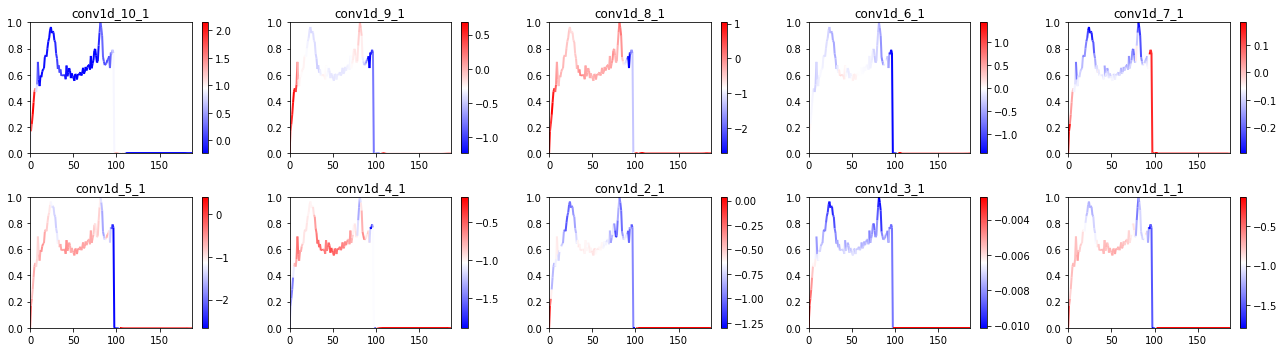

In [16]:
display_conv_activations(resnet_model,xval_r[not_normal[0]])